# Intuition

We can have 2 kinds of predictions:

1. Given that the customer has not bought before, 
    1. Can we use their demographics to determine:
        1. How much (dollar amount) they will buy?
        2. How many items they will buy?
        3. What categories they will buy?
2. Given that the customer has made a purchase, 
    1. Can we see if their demographics, purchase history and purchase experience determine the likelihood of them returning?
        1. Compare the non-last transactions of repeat customers against transactions by single-time customers
    2. Can we compare past purchases to future ones? 
        1. E.g. to see if big spenders always spend big for all purchases. 
          Or those that buy from a certain category will continue to buy from that category. 
    3. Can we segment customers based on their purchase history? 
        1. Can also explore if particular segments have higher chance of returning customers. 
    
Can we segment customers based on what they purchase? E.g.:
* Those that purchase huge range of products
* Those that purchase only 1 item

# Import Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython.display import Markdown, display
from pandas_profiling import ProfileReport
from sklearn.metrics import precision_score, recall_score
from tabulate import tabulate
from tqdm import tqdm_notebook

sns.set(rc={'figure.figsize':(14, 6)})

tqdm_notebook().pandas()

C:\Users\leeye\Anaconda3\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(BACKEND)


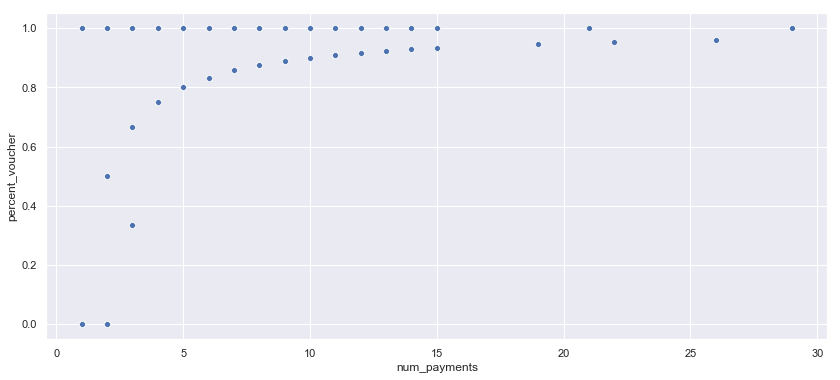

In [91]:
sns.scatterplot(order_payments.num_payments, order_payments.percent_voucher)

In [3]:
customers = pd.read_csv("data/olist_customers_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv").set_index('product_id')
products.product_category_name.fillna('others', inplace=True)
order_items = order_items.join(products, on='product_id').drop(['order_item_id'], axis=1)

order_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
order_payments = order_payments.groupby('order_id').agg({'payment_type': ['size', 'nunique', lambda x: (x == 'voucher').sum() / x.shape[0]], 'payment_installments': ['sum']})
order_payments.columns = ['num_payments', 'nunique_payments', 'percent_voucher', 'num_installments']

for col in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
    orders[col] = pd.to_datetime(orders[col])
    
state_data = pd.read_csv("data/brazil_state_data.csv")
state_data.set_index('state', inplace=True)
state_data['gdp_per_capita'] = state_data['gdp'] / state_data['population']
state_data['population_density'] = state_data['population'] / state_data['size']
customers = customers.join(state_data, on='customer_state')

orders = orders.merge(customers, on='customer_id').drop('customer_id', axis=1).join(order_payments, on='order_id')

* GDP Data: https://agenciadenoticias.ibge.gov.br/en/agencia-press-room/2185-news-agency/releases-en/10155-gdp-of-municipalities-agriculture-represents-more-than-half-of-economic-activity-in-1-135-municipalities
* Population Data: https://en.wikipedia.org/wiki/List_of_Brazilian_federative_units_by_gross_regional_product 
* Size Data: http://www.brazil-help.com/brazilian_states.htm

# Data Preparation

## Joining and preparing data columns

In [4]:
orders['time_to_approve'] = (orders.order_approved_at - orders.order_purchase_timestamp).dt.total_seconds()
orders['time_to_ship'] = (orders.order_delivered_carrier_date - orders.order_approved_at).dt.total_seconds()
orders['time_to_reach'] = (orders.order_delivered_customer_date - orders.order_delivered_carrier_date).dt.total_seconds()
orders['days_delivery_diff'] = (orders.order_estimated_delivery_date - orders.order_delivered_customer_date).dt.days
orders['month_purchase'] = orders.order_purchase_timestamp.dt.month

In [5]:
orders['customer_num_order'] = orders.groupby('customer_unique_id')['order_purchase_timestamp'].rank()

In [6]:
max_num_orders = pd.DataFrame(customers.customer_unique_id.value_counts())
max_num_orders.columns = ['max_num_orders']

In [7]:
order_details = order_items.groupby('order_id').agg({'price': ['size', 'sum', 'mean'], 'freight_value': ['sum', 'mean'], 'product_id': ['nunique'], 'seller_id': ['nunique']})
cols = ['_'.join(col) for col in order_details.columns]
cols[0] = 'num_items'
order_details.columns = cols

In [8]:
order_reviews = reviews.groupby('order_id').agg({'review_score': ['size', 'mean']})
order_reviews.columns = ['num_reviews', 'avg_review']

In [9]:
orders = orders.join(max_num_orders, on='customer_unique_id').join(order_details, on='order_id').join(order_reviews, on='order_id')

## Converting Categories

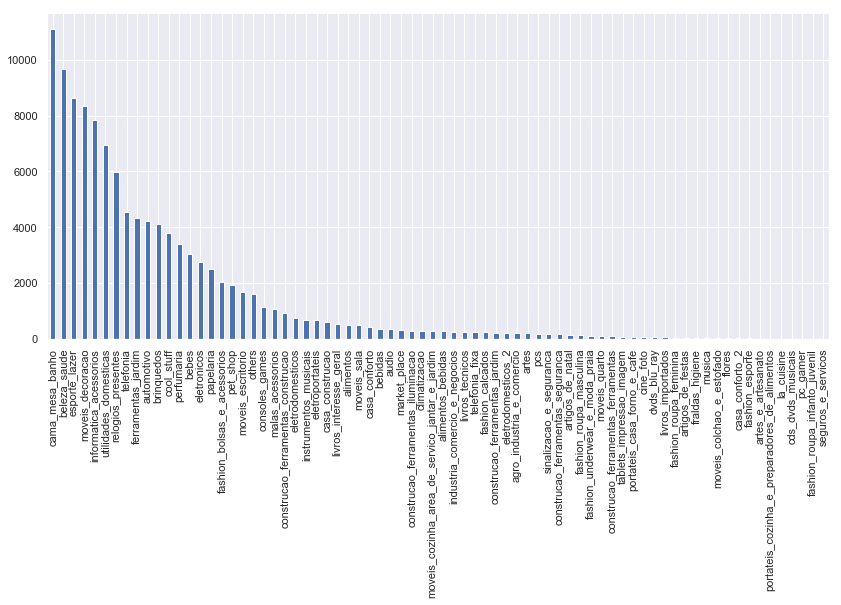

In [15]:
order_items.product_category_name.value_counts().plot(kind='bar')

In [10]:
first_n = 25
percent = order_items.product_category_name.value_counts()[:first_n].sum() / order_items.shape[0] * 100
display(Markdown("The first {} categories account for {:.2f}% of all orders. Let's convert the rest to \"others\".".format(first_n, percent)))

The first 25 categories account for 91.64% of all orders. Let's convert the rest to "others".

In [11]:
categories = pd.DataFrame(order_items.product_category_name.value_counts())
categories['product_category_name'] = categories.index
categories[first_n:]['product_category_name'] = 'others'

C:\Users\leeye\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
if 'product_category' in order_items.columns:
    order_items.drop('product_category', axis=1, inplace=True)
categories.columns = ['product_category']
order_items = order_items.join(categories, on='product_category_name')

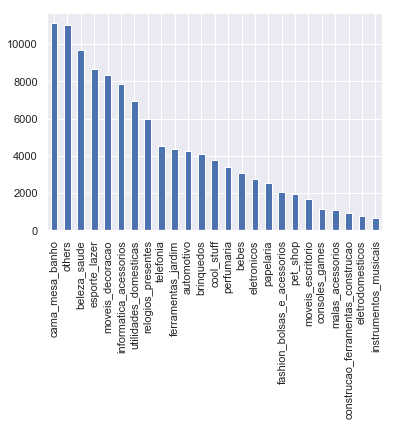

In [13]:
order_items.product_category.value_counts().plot(kind='bar')

# Some EDA

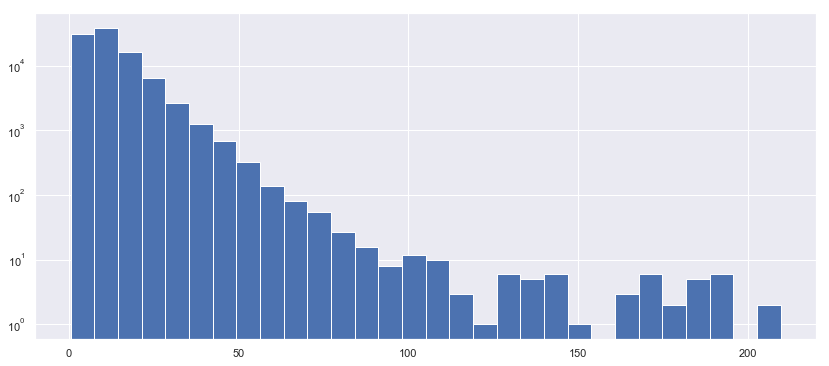

In [105]:
((orders.time_to_approve + orders.time_to_ship + orders.time_to_reach) / 86400).hist(bins = 30)
plt.yscale('log')

In [23]:
orders[['order_purchase_timestamp']].set_index('order_purchase_timestamp').resample('W').size().sort_values(ascending=False)

order_purchase_timestamp
2017-11-26    3008
2017-12-03    2098
2018-08-05    2058
2018-08-12    1988
2018-05-13    1987
2018-03-04    1903
2018-08-19    1875
2018-05-20    1837
2018-01-14    1785
2018-05-06    1770
2018-02-25    1756
2018-01-21    1750
2018-03-25    1716
2017-12-10    1692
2018-07-22    1678
2018-04-29    1676
2018-04-22    1672
2018-07-29    1646
2018-03-11    1643
2018-02-18    1640
2018-02-04    1598
2018-03-18    1595
2018-01-28    1591
2018-04-08    1590
2018-02-11    1584
2018-04-15    1554
2018-06-17    1514
2018-04-01    1471
2018-06-24    1457
2018-06-10    1438
              ... 
2017-01-29     354
2016-10-09     283
2017-01-22     197
2018-09-02     130
2017-01-15      80
2017-01-08      46
2016-10-16      39
2018-09-09       7
2018-09-16       4
2018-09-30       3
2016-09-18       2
2018-10-21       2
2018-10-07       2
2018-09-23       2
2016-09-04       1
2016-12-25       1
2016-09-11       1
2016-10-02       1
2016-10-23       1
2016-09-25       0
2018-1

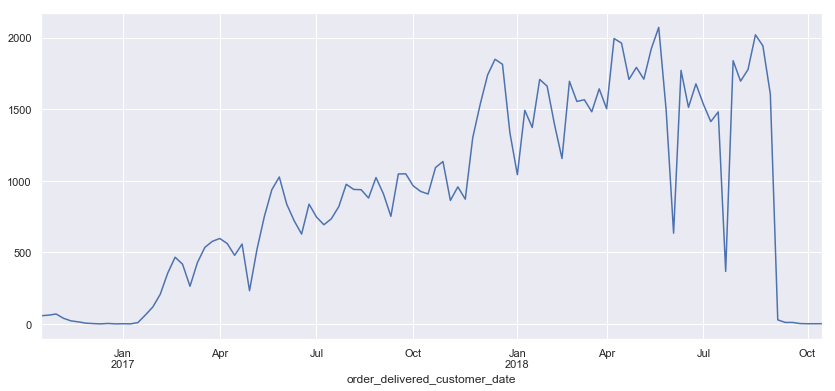

In [628]:
orders[['order_delivered_customer_date']].set_index('order_delivered_customer_date').resample('W').size().plot()

## Analysing Sellers vs Products

In [42]:
repeats = (customers.customer_unique_id.value_counts().value_counts(normalize=True).sort_index() * 100)
repeats[3:].sum()

0.05099067599067599

In [377]:
tmp = order_items.join(orders.set_index('order_id'), on='order_id')

In [389]:
tmp[['seller_id', 'product_id']].drop_duplicates().groupby('product_id').size().sort_values(ascending=False).head()

product_id
d285360f29ac7fd97640bf0baef03de0    8
69455f41626a745aea9ee9164cb9eafd    8
4298b7e67dc399c200662b569563a2b2    7
36f60d45225e60c7da4558b070ce4b60    7
656e0eca68dcecf6a31b8ececfabe3e8    7
dtype: int64

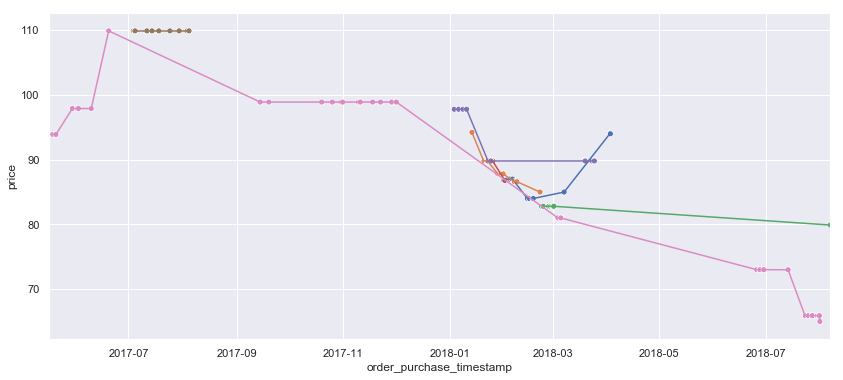

In [396]:
t = tmp[['order_purchase_timestamp', 'seller_id', 'product_id', 'price']].drop_duplicates()
t = t[t.product_id == '656e0eca68dcecf6a31b8ececfabe3e8'].sort_values(['seller_id', 'order_purchase_timestamp'])
sns.lineplot(t.order_purchase_timestamp, t.price, hue=t.seller_id)
sns.scatterplot(t.order_purchase_timestamp, t.price, hue=t.seller_id)
plt.xlim(t.order_purchase_timestamp.min(), t.order_purchase_timestamp.max())
plt.legend().remove()

# Analysis

In [136]:
from sklearn.metrics import mean_squared_error

In [137]:
def stepwise_regression(model_type, df, y):
    
    def process(cols):
        X = sm.add_constant(df[cols])
        if model_type == "ols":
            model = sm.OLS(y, X).fit(disp = 0)
        else:
            model = sm.Logit(y, X).fit(disp = 0)
        pred_y = round(model.predict(X))
        return (model, pred_y)
    
    selected_columns = []
    available_columns = df.columns
    best_score = 0
    best_pred_y = pd.Series()
    while len(selected_columns) < len(available_columns):
        col_to_add = None
        for col in available_columns:
            if col in selected_columns:
                continue
            # Build a model with each col
            X = sm.add_constant(df[selected_columns + [col]])
            model, pred_y = process(selected_columns + [col])
            if model_type == "ols":
                score = mean_squared_error(y, pred_y)
            else:
                score = recall_score(y, pred_y)
            if score > best_score:
                best_score = score
                col_to_add = col
                best_pred_y = pred_y
            
        if col_to_add is None:
            # Couldn't find anything better
            X = sm.add_constant(df[selected_columns])
            model, pred_y = process(selected_columns)
            return (model, best_score, pred_y)
        else:
            selected_columns.append(col_to_add)
    X = sm.add_constant(df[selected_columns])
    model, pred_y = process(selected_columns)
    return (model, best_score, pred_y)

## Analysing All Customers

### Using Demographics to Predict Purchase Volume

In [53]:
customers.customer_zip_code_prefix.nunique()

14994

In [45]:
orders[['price_sum', 'num_items', 'customer_state', 'gdp', 'size', 'population', 'customer_city', 'customer_zip_code_prefix']].head()

,price_sum,num_items,customer_state,gdp,size,population,customer_city,customer_zip_code_prefix
0,29.99,1.0,SP,628064882,248209,44035304,sao paulo,3149
1,118.70,1.0,BA,56624041,564692,15126371,barreiras,47813
2,159.90,1.0,GO,46094735,340086,6523222,vianopolis,75265
3,45.00,1.0,RN,19076030,52796,3408510,sao goncalo do amarante,59296
4,19.90,1.0,SP,628064882,248209,44035304,santo andre,9195


In [94]:
orders[['gdp', 'size', 'population']].corr()

,gdp,size,population
gdp,1.000000,-0.218696,0.951113
size,-0.218696,1.000000,-0.003085
population,0.951113,-0.003085,1.000000


In [115]:
for y_col in ['price_sum', 'avg_review', 'num_items', 'seller_id_nunique']:
    display(Markdown("# " + y_col))
    subset = orders[['population', 'gdp_per_capita', 'size', 'population_density', y_col]].dropna() # excluded GDP because high correlation
    subset = np.log1p(subset)
    X = sm.add_constant(subset.drop(y_col, axis=1))
    y = subset[y_col]

    while True:
        model = sm.OLS(y, X).fit()
        pvals = pd.DataFrame(model.pvalues).drop('const')
        max_pval = pvals.max()[0]
        if max_pval > 0.05:
            to_drop = pvals[pvals[0] == pvals[0].max()].index[0]
            display(Markdown("Dropping `" + to_drop + "` (p-val: `{:.4f}`)".format(max_pval)))
            X.drop(to_drop, inplace=True, axis=1)
        else:
            # no columns with pval > 0.05
            break
    display(model.summary())
#     model, best_score, pred_y = stepwise_regression('ols', subset.drop(y, axis=1), subset[y])
#     display(model.summary())

# price_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_sum   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     137.7
Date:                Tue, 23 Apr 2019   Prob (F-statistic):          1.59e-117
Time:                        18:21:35   Log-Likelihood:            -1.3136e+05
No. Observations:               98666   AIC:                         2.627e+05
Df Residuals:                   98661   BIC:                         2.628e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.5228      0.069     80.283      0.000       5.388       5.658
population            -0.9554      0.168     -5.700      0.000      -1.284      -0.627
gdp_per_capita        -0.0744      0.011     -6.776      0.000      -0.096      -0.053
size                   0.8887      0.168      5.276      0.000       0.559       1.219
population_density     0.9357      0.176      5.320      0.000       0.591       1.280
==============================================================================
Omnibus:                     1608.475   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1779.211
Skew:                           0.283   Prob(JB):                         0.00
Kurtosis:                       3.337   Cond. No.                     2.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# avg_review

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_review   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     90.45
Date:                Tue, 23 Apr 2019   Prob (F-statistic):           6.87e-77
Time:                        18:21:35   Log-Likelihood:                -39245.
No. Observations:               99441   AIC:                         7.850e+04
Df Residuals:                   99436   BIC:                         7.855e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.3009      0.027     48.429      0.000       1.248       1.354
population             0.5218      0.066      7.966      0.000       0.393       0.650
gdp_per_capita         0.0396      0.004      9.245      0.000       0.031       0.048
size                  -0.4989      0.066     -7.580      0.000      -0.628      -0.370
population_density    -0.5419      0.069     -7.883      0.000      -0.677      -0.407
==============================================================================
Omnibus:                    26336.072   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53125.872
Skew:                          -1.657   Prob(JB):                         0.00
Kurtosis:                       4.358   Cond. No.                     2.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# num_items

Dropping `gdp_per_capita` (p-val: `0.5990`)

Dropping `population` (p-val: `0.0945`)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              num_items   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.368
Date:                Tue, 23 Apr 2019   Prob (F-statistic):             0.0127
Time:                        18:21:35   Log-Likelihood:                 36476.
No. Observations:               98666   AIC:                        -7.295e+04
Df Residuals:                   98663   BIC:                        -7.292e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7125      0.011     65.209      0.000       0.691       0.734
size                   0.0019      0.001      2.631      0.009       0.000       0.003
population_density     0.0019      0.001      2.720      0.007       0.001       0.003
==============================================================================
Omnibus:                    80961.484   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1805148.944
Skew:                           3.975   Prob(JB):                         0.00
Kurtosis:                      22.388   Cond. No.                         269.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# seller_id_nunique

Dropping `size` (p-val: `0.6058`)

Dropping `gdp_per_capita` (p-val: `0.2984`)

Dropping `population_density` (p-val: `0.1563`)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      seller_id_nunique   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.803
Date:                Tue, 23 Apr 2019   Prob (F-statistic):             0.0284
Time:                        18:21:35   Log-Likelihood:             1.5938e+05
No. Observations:               98666   AIC:                        -3.188e+05
Df Residuals:                   98664   BIC:                        -3.187e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6921      0.003    231.737      0.000       0.686       0.698
population     0.0004      0.000      2.191      0.028    4.12e-05       0.001
==============================================================================
Omnibus:                   143554.030   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         33374628.203
Skew:                           9.144   Prob(JB):                         0.00
Kurtosis:                      91.226   Cond. No.                         329.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
pvals.drop('const')

,0
population,0.078217
gdp_per_capita,0.856621
size,0.402736
population_density,0.830672


Dropping gdp_per_capita (p-val: 0.8566)
Dropping population_density (p-val: 0.9046)
Dropping size (p-val: 0.2205)
Dropping population (p-val: 0.0760)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      seller_id_nunique   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Tue, 23 Apr 2019   Prob (F-statistic):                nan
Time:                        18:10:15   Log-Likelihood:                 67327.
No. Observations:               98666   AIC:                        -1.347e+05
Df Residuals:                   98665   BIC:                        -1.346e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0136      0.000   2603.414      0.000       1.013       1.014
==============================================================================
Omnibus:                   151977.566   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         61892385.863
Skew:                           9.971   Prob(JB):                         0.00
Kurtosis:                     124.068   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
X.shape

(98666, 5)

In [52]:
y.shape

(98666,)

In [57]:
model.tvalues

const                 795.432947
population              1.761143
gdp_per_capita          0.180678
size                    0.836748
population_density     -0.213841
dtype: float64

In [122]:
for y_col in ['price_sum', 'num_items', 'seller_id_nunique']:
    display(Markdown("# " + y_col))
    sub = orders[[y_col, 'gdp_per_capita', 'size']].dropna()
    X2 = sm.add_constant(sub.drop(y_col, axis=1))
    X2['gdp_per_capita'] = np.log1p(X2['gdp_per_capita'])
    X2['size'] = np.log1p(X2['size'])
    est = sm.OLS(np.log1p(sub[y_col]), X2)
    est2 = est.fit()
    display(est2.summary())

# price_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_sum   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.59
Date:                Tue, 23 Apr 2019   Prob (F-statistic):           2.52e-05
Time:                        14:32:09   Log-Likelihood:            -6.6787e+05
No. Observations:               98666   AIC:                         1.336e+06
Df Residuals:                   98663   BIC:                         1.336e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            139.7726      1.701     82.161      0.000     136.438     143.107
gdp_per_capita    -0.2628      0.074     -3.541      0.000      -0.408      -0.117
size            4.259e-06   3.56e-06      1.195      0.232   -2.73e-06    1.12e-05
==============================================================================
Omnibus:                   155664.544   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        293055456.906
Skew:                           9.731   Prob(JB):                         0.00
Kurtosis:                     269.281   Cond. No.                     8.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# num_items

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              num_items   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1182
Date:                Tue, 23 Apr 2019   Prob (F-statistic):              0.888
Time:                        14:32:09   Log-Likelihood:                -78921.
No. Observations:               98666   AIC:                         1.578e+05
Df Residuals:                   98663   BIC:                         1.579e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.1408      0.004    262.299      0.000       1.132       1.149
gdp_per_capita  8.298e-05      0.000      0.437      0.662      -0.000       0.000
size           -9.673e-11   9.11e-09     -0.011      0.992    -1.8e-08    1.78e-08
==============================================================================
Omnibus:                   132810.611   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         55156239.033
Skew:                           7.527   Prob(JB):                         0.00
Kurtosis:                     117.847   Cond. No.                     8.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# seller_id_nunique

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      seller_id_nunique   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7834
Date:                Tue, 23 Apr 2019   Prob (F-statistic):              0.457
Time:                        14:32:09   Log-Likelihood:                 67327.
No. Observations:               98666   AIC:                        -1.346e+05
Df Residuals:                   98663   BIC:                        -1.346e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0128      0.001   1025.314      0.000       1.011       1.015
gdp_per_capita   1.21e-05   4.31e-05      0.281      0.779   -7.23e-05    9.65e-05
size            2.537e-09   2.07e-09      1.226      0.220   -1.52e-09    6.59e-09
==============================================================================
Omnibus:                   151974.012   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         61878181.375
Skew:                           9.970   Prob(JB):                         0.00
Kurtosis:                     124.053   Cond. No.                     8.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Using Demographics to Predict Purchase Items

In [163]:
subset = orders[['order_id', 'gdp_per_capita', 'gdp', 'population', 'size', 'population_density']].join(order_items.set_index('order_id')[['product_category']], on='order_id', how='right').drop('order_id', axis=1)

In [160]:
subset.groupby('product_category')['gdp_per_capita'].mean()

product_category
automotivo                           11.933927
bebes                                11.937448
beleza_saude                         12.205829
brinquedos                           12.362574
cama_mesa_banho                      12.585952
consoles_games                       12.341583
construcao_ferramentas_construcao    11.830202
cool_stuff                           11.584447
eletrodomesticos                     11.952558
eletronicos                          11.751040
esporte_lazer                        12.274424
fashion_bolsas_e_acessorios          11.715178
ferramentas_jardim                   11.256768
informatica_acessorios               11.845284
instrumentos_musicais                11.199534
malas_acessorios                     11.812197
moveis_decoracao                     11.903564
moveis_escritorio                    11.743079
others                               12.222114
papelaria                            11.994282
perfumaria                           12.467

# gdp_per_capita

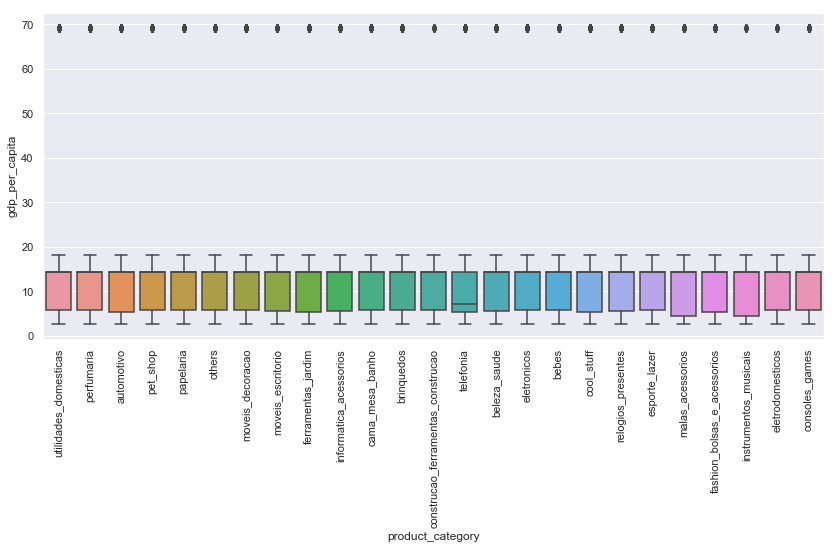

# gdp

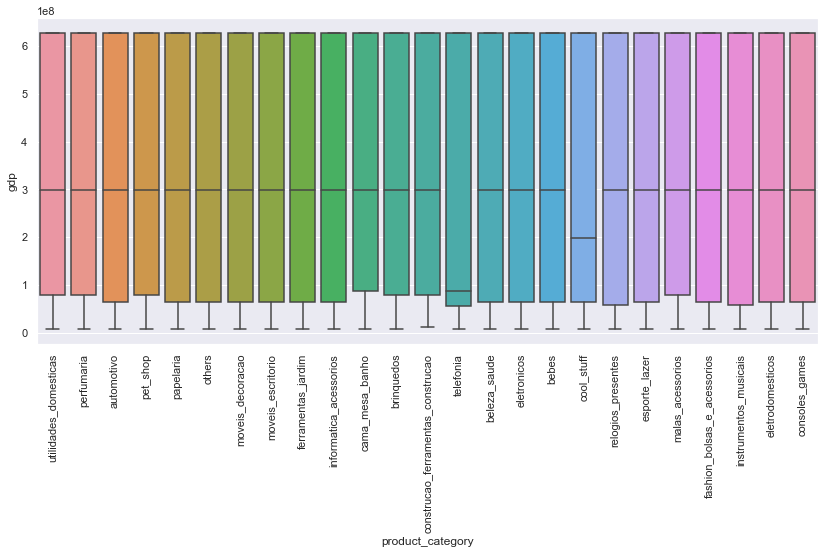

# population

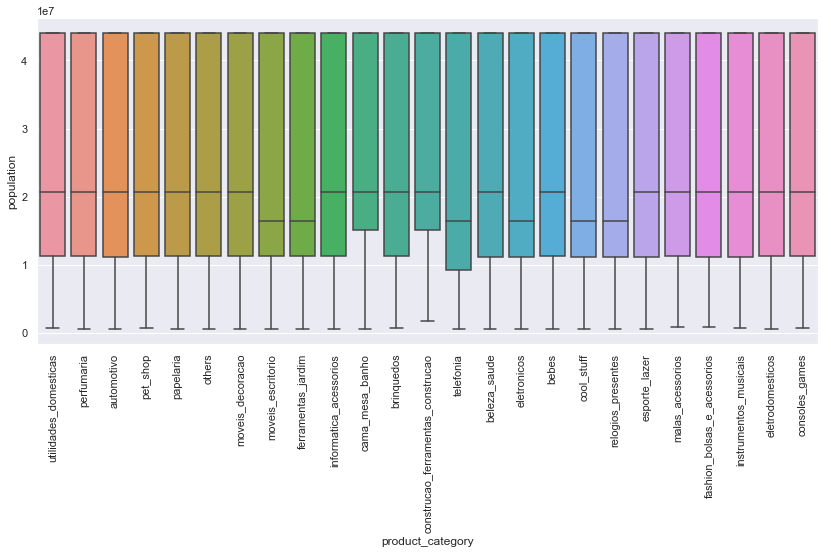

# size

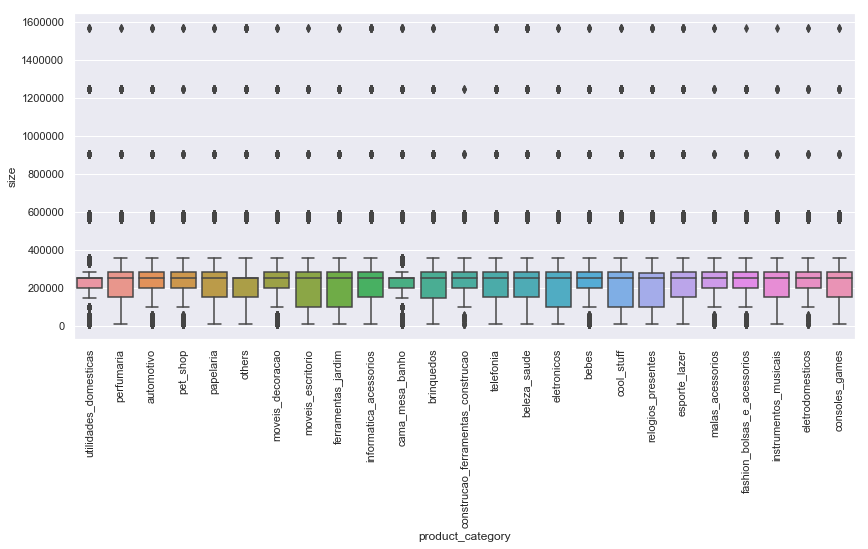

# population_density

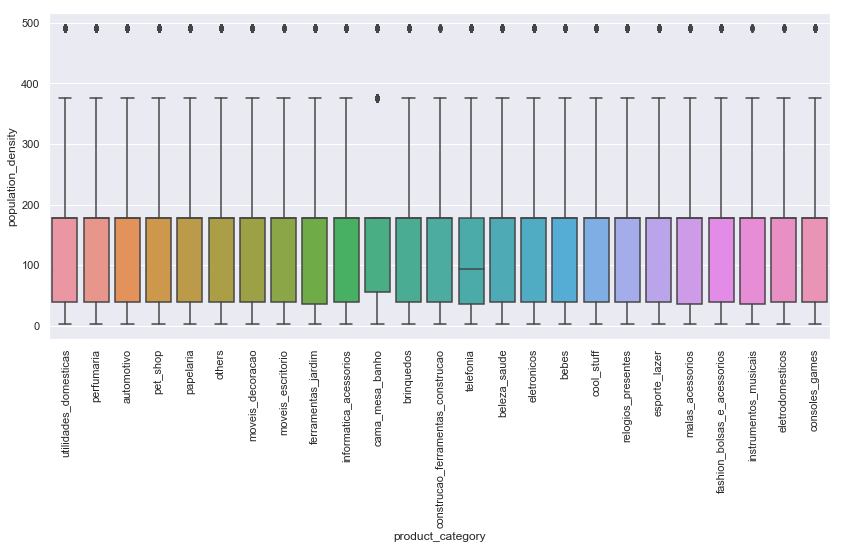

In [164]:
for col in ['gdp_per_capita', 'gdp', 'population', 'size', 'population_density']:
    display(Markdown("# " + col))
    sns.boxplot(subset.product_category, subset[col], showfliers=True)
    plt.xticks(rotation=90)
#     plt.yticks(np.exp(plt.yticks()[0]-1))
#     plt.yscale('log')
    plt.show()

## Analysing Return Customers

### See if demographics, purchase history and purchase experience determine the likelihood of customers returning

In [166]:
orders_filtered = orders[(orders.max_num_orders == 1) | ((orders.max_num_orders > 1) & (orders.max_num_orders > orders.customer_num_order))]

In [167]:
for month in range(1, 13):
    subset = orders_filtered[orders_filtered.month_purchase == month]
    print("Month{: 3}: {:.2f}% repeat customers".format(month, (subset.max_num_orders > 1).sum() / subset.shape[0] * 100))

Month  1: 4.26% repeat customers
Month  2: 4.65% repeat customers
Month  3: 3.70% repeat customers
Month  4: 3.15% repeat customers
Month  5: 3.50% repeat customers
Month  6: 3.19% repeat customers
Month  7: 3.59% repeat customers
Month  8: 2.97% repeat customers
Month  9: 5.50% repeat customers
Month 10: 4.46% repeat customers
Month 11: 3.99% repeat customers
Month 12: 3.44% repeat customers


C:\Users\leeye\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, '% of customers who return later on')

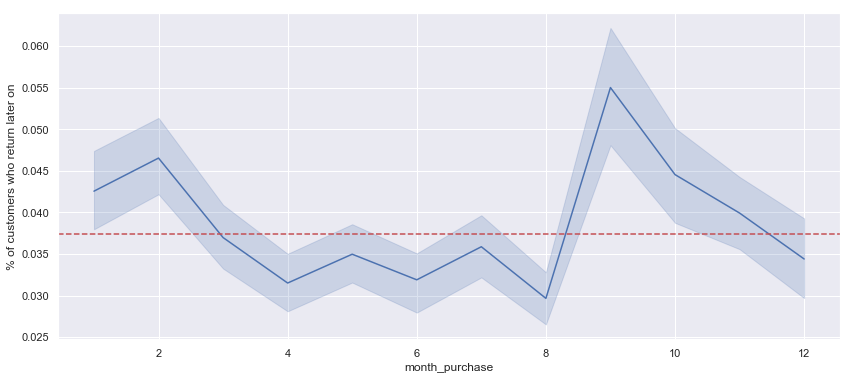

In [168]:
sns.lineplot(orders_filtered.month_purchase, orders_filtered.max_num_orders > 1)
plt.axhline(y = (orders_filtered.max_num_orders > 1).sum() / orders_filtered.shape[0], color = 'r', linestyle='--')
plt.ylabel("% of customers who return later on")

From the above plot, we can see that there is a discernible difference in % of recurring customers for each month. 

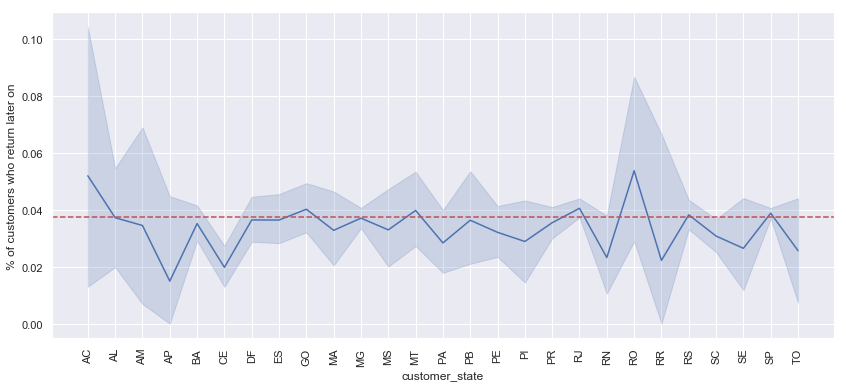

In [169]:
sns.lineplot(orders_filtered.customer_state, orders_filtered.max_num_orders > 1)
plt.axhline(y = (orders_filtered.max_num_orders > 1).sum() / orders_filtered.shape[0], color = 'r', linestyle='--')
plt.ylabel("% of customers who return later on")
_ = plt.xticks(rotation=90)

From the above plot, we can also see that there is a discernible difference in % of recurring customers for each state. 

In [214]:
tmp = pd.DataFrame(orders_filtered.groupby(['customer_state', 'month_purchase'])['max_num_orders'].agg(lambda x: (x > 1).sum() / x.shape[0])).reset_index().pivot(index='customer_state', columns='month_purchase')
tmp.columns = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

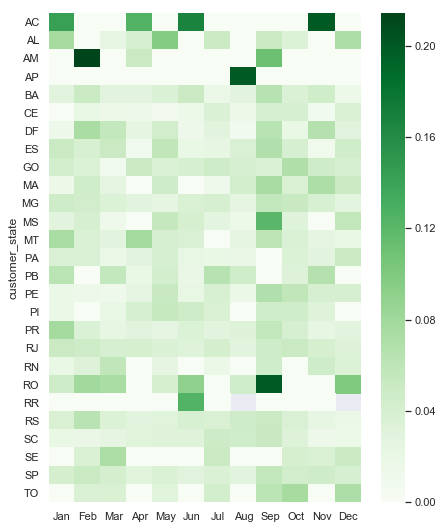

In [215]:
plt.figure(figsize=(7, 9))
sns.heatmap(tmp, cmap='Greens')
_ = plt.yticks(rotation=0)

In [89]:
# remove population (high correlation), size, gdp_per_capita, seller_id_nunique, avg_review (high p-value)

# subset = orders_filtered[['max_num_orders', 'gdp', 'time_to_approve', 
#         'time_to_ship', 'time_to_reach', 'days_delivery_diff', 
#         'num_items', 'price_sum', 'freight_value_mean', 'month_purchase', 
#         'num_reviews']]

subset = orders_filtered[['max_num_orders', 'gdp', 'time_to_approve', 
                          'size', 'gdp_per_capita', 'seller_id_nunique', 'avg_review',
                          'time_to_ship', 'time_to_reach', 'days_delivery_diff', 
                          'num_items', 'price_sum', 'freight_value_mean', 'month_purchase', 
                          'num_reviews']]


for col in subset.columns:
    if (subset[col].isna().sum() > 0) and (subset[col].dtype == float or subset[col].dtype == int):
        subset[col] = subset[col].fillna(subset[col].mean())
        
for col in ['freight_value_sum', 'freight_value_mean', 'gdp_per_capita', 'num_items', 'price_sum', 'size', 'time_to_approve']:
    if col in subset.columns:
        subset[col] = np.log1p(subset[col])

subset['y'] = subset.max_num_orders > 1
subset.drop('max_num_orders', inplace=True, axis=1)

C:\Users\yenter\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yenter\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yenter\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [173]:
model, best_score, pred_y = stepwise_regression(subset.drop(['y', 'month_purchase'], axis=1), subset.y)
print("Recall: {:.3f}%".format(best_score * 100))

Recall: 8.937%


In [174]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                96713
Model:                          Logit   Df Residuals:                    96711
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Apr 2019   Pseudo R-squ.:                 0.05656
Time:                        21:38:27   Log-Likelihood:                -14552.
converged:                       True   LL-Null:                       -15425.
                                        LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -8.0209      0.128    -62.857      0.000      -8.271      -7.771
num_reviews     4.6793      0.124     37.781      0.000       4.437       4.922
===============================================================================
"""

In [600]:
# ProfileReport(subset.drop('y', axis=1))

In [186]:
true_y = pd.Series()
pred_y = pd.Series()
month_recalls = []

for month in tqdm_notebook(range(1, 13)):
    X = subset[subset.month_purchase == month].drop(['y', 'month_purchase'], axis=1)
    y = subset[subset.month_purchase == month].y
    
    pred = round(model.predict(sm.add_constant(X[['num_reviews']])))
    true_y = true_y.append(y)
    pred_y = pred_y.append(pred)
    month_recalls.append(recall_score(y, pred) * 100)
    
#     model, best_score, pred_y_found = stepwise_regression(X, y)
#     true_y = true_y.append(y)
#     pred_y = pred_y.append(pred_y_found)
#     display(Markdown("# Month " + str(month)))
#     display(model.summary())
#     display(Markdown("Recall: {:.3f}%".format(best_score * 100)))
#     month_recalls.append(best_score * 100)

print("Precision: {: 7.3f}%".format(precision_score(true_y, pred_y) * 100))
print("Recall:    {: 7.3f}%".format(recall_score(true_y, pred_y) * 100))


Precision:  79.361%
Recall:      8.937%


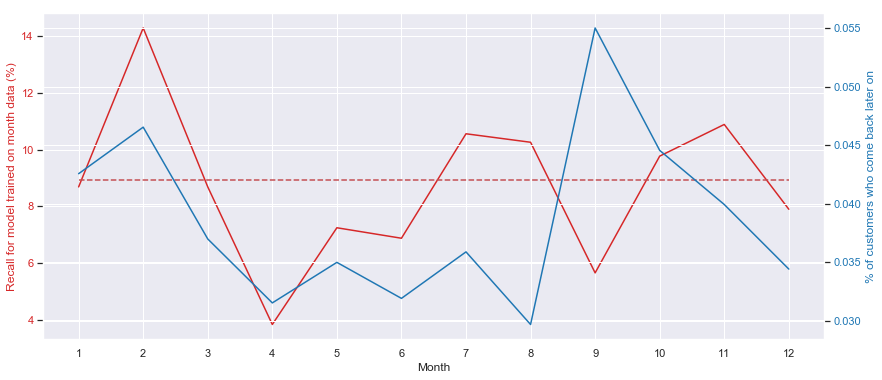

In [187]:
fig, ax1 = plt.subplots()
p = sns.lineplot(range(1, 13), month_recalls, ax=ax1, color='tab:red')
ax1.plot(range(1, 13), [recall_score(true_y, pred_y) * 100] * 12, 'r--')
ax1.set_xlabel("Month")
ax1.set_ylabel("Recall for model trained on month data (%)", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
_ = plt.xticks(range(1, 13))
ax2 = ax1.twinx()
sns.lineplot(orders_filtered.month_purchase, orders_filtered.max_num_orders > 1, err_style=None, ax=ax2, color='tab:blue')
ax2.set_ylabel("% of customers who come back later on", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Clustering Customers

In [629]:
order_items_joined = orders.join(order_items.set_index('order_id'), on='order_id')[['customer_unique_id', 'product_category', 'price', 'freight_value']]
order_items_joined = pd.DataFrame(order_items_joined.groupby('customer_unique_id').progress_apply(lambda x: [list(y) for y in x.drop('customer_unique_id', axis=1).to_records(index=False)]))
order_items_joined.columns = ['purchases']

KeyError: "['product_category'] not in index"

In [331]:
customers_joined = customers.set_index('customer_unique_id').join(order_items_joined)

In [332]:
customers_joined

,customer_id,customer_zip_code_prefix,customer_city,customer_state,gdp,size,population,gdp_per_capita,purchases
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,7787,cajamar,SP,628064882,248209,44035304,14.262758,"[[cama_mesa_banho, 129.9, 12.0]]"
0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,6053,osasco,SP,628064882,248209,44035304,14.262758,"[[beleza_saude, 18.9, 8.29]]"
0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,88115,sao jose,SC,17328527,95346,6727148,2.575910,"[[papelaria, 69.0, 17.22]]"
0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,66812,belem,PA,28706165,1247689,8073924,3.555417,"[[telefonia, 25.99, 17.63]]"
0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,18040,sorocaba,SP,628064882,248209,44035304,14.262758,"[[telefonia, 180.0, 16.89]]"
0004bd2a26a76fe21f786e4fbd80607f,4a913a170c26e3c8052ed0202849b5a8,5036,sao paulo,SP,628064882,248209,44035304,14.262758,"[[ferramentas_jardim, 154.0, 12.98]]"
00050ab1314c0e55a6ca13cf7181fecf,d2509c13692836fc0449e88cf9eb4858,13084,campinas,SP,628064882,248209,44035304,14.262758,"[[telefonia, 27.99, 7.39]]"
00053a61a98854899e70ed204dd4bafe,a81ebb9b32f102298c0c89635b4b3154,80410,curitiba,PR,78892229,199315,11081692,7.119150,"[[esporte_lazer, 191.0, 18.59], [esporte_lazer..."
0005e1862207bf6ccc02e4228effd9a0,3b37fb626fdf46cd99d37ec62afa88ff,25966,teresopolis,RJ,299849795,43696,16461173,18.215579,"[[fashion_bolsas_e_acessorios, 135.0, 15.12]]"


In [431]:
from sklearn.cluster import DBSCAN
import scipy.sparse
from progressbar import ProgressBar

In [421]:
def get_categories(purchases):
    result = set()
    for purchase in purchases:
        result.add(purchase[0])
    return result

In [633]:
num_customers = customers.shape[0]
num_customers = round(num_customers * 0.5) # if we get memory error from trying to build the full array

In [634]:
categories = {}

for i in tqdm_notebook(range(num_customers)):
    categories[i] = get_categories(customers_joined.iloc[i].purchases)

In [635]:
distances = np.zeros([num_customers, num_customers], np.float16)
bar = ProgressBar(max_value=(num_customers-1) * (num_customers) / 2)
count = 0
for i in range(num_customers-1):
    distances[i][i] = 1
    for j in range(i+1, num_customers):
        # calc distance
        # using jaccard index
        intersect = len(categories[i] & categories[j])
        if (intersect > 0):
            distance = intersect / len(categories[i] | categories[j])
            distances[i][j] = distance
            distances[j][i] = distance
    count += (num_customers - i - 2)
    bar.update(count)
bar.finish()

100% (1236014340.0 of 1236014340.0) |####| Elapsed Time: 0:06:48 Time:  0:06:48


In [636]:
distances = 1 - distances

In [640]:
clustering = DBSCAN(metric='precomputed').fit(distances)

C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


MemoryError: 

In [ ]:
pd.Series(clustering.labels_).value_counts()

# Random. 

Analysing sellers and products

In [337]:
order_items.product_id.nunique() / order_items.shape[0]

0.29250776742121615

In [343]:
order_items[['product_id']].drop_duplicates().shape[0]

32951

In [344]:
products.shape

(32951, 8)

# Others

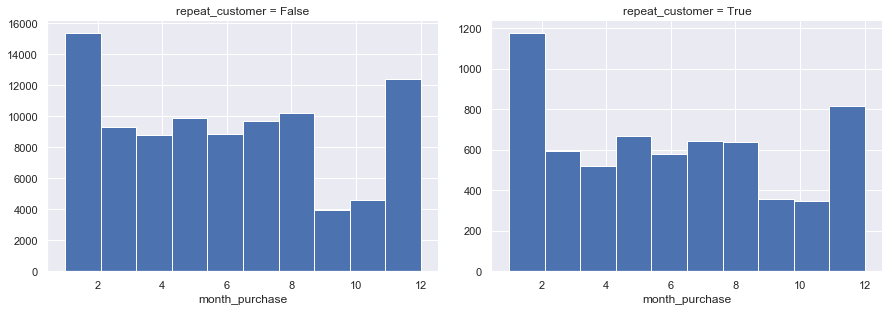

In [170]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "month_purchase")

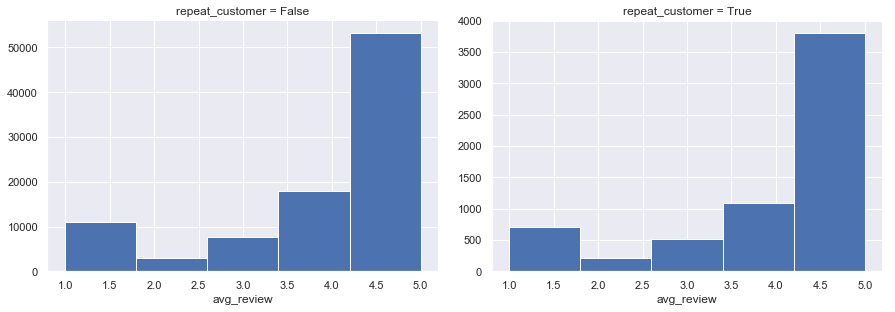

In [180]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "avg_review", bins=5)

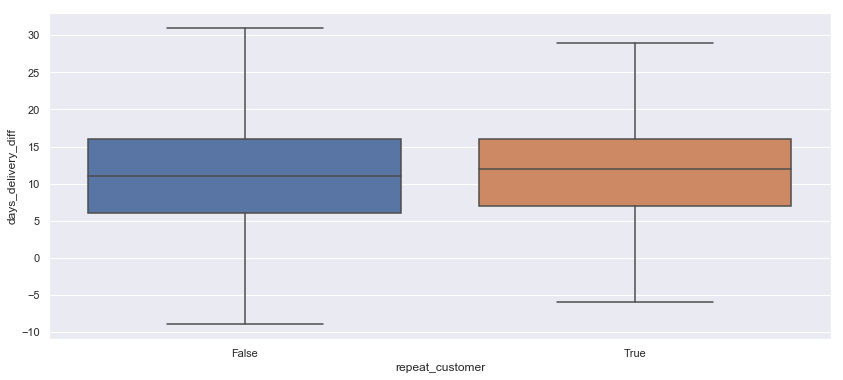

In [197]:
sns.boxplot(orders.repeat_customer, orders.days_delivery_diff, showfliers=False)

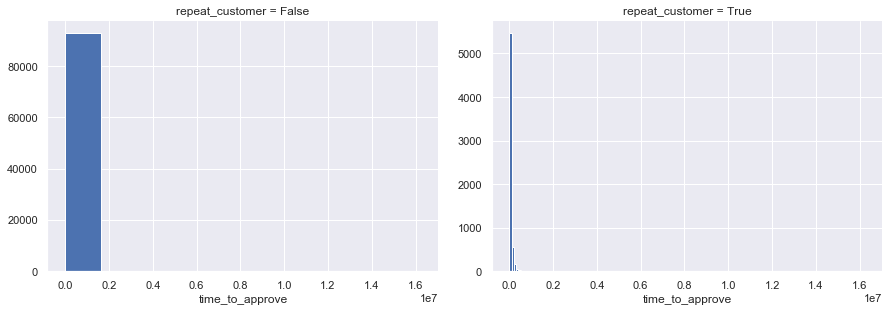

In [201]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "time_to_approve")

In [222]:
orders['time_to_approve_bins'] = pd.qcut(orders.time_to_approve, 10)

In [246]:
results = []
for category in orders['time_to_approve_bins'].cat.categories:
    sub = orders[orders.time_to_approve_bins == category]
    results.append([category, "{0:.3f}".format(sub.repeat_customer.sum() / sub.shape[0] * 100)])
print(tabulate(results, headers=('time_to_approve', '% repeat')))

time_to_approve           % repeat
----------------------  ----------
(-0.001, 605.0]              6.846
(605.0, 721.0]               6.821
(721.0, 832.0]               6.767
(832.0, 978.0]               6.12
(978.0, 1236.0]              6.471
(1236.0, 2214.0]             5.623
(2214.0, 21798.0]            6.487
(21798.0, 76783.0]           6.104
(76783.0, 124775.0]          5.852
(124775.0, 16233050.0]       6.144


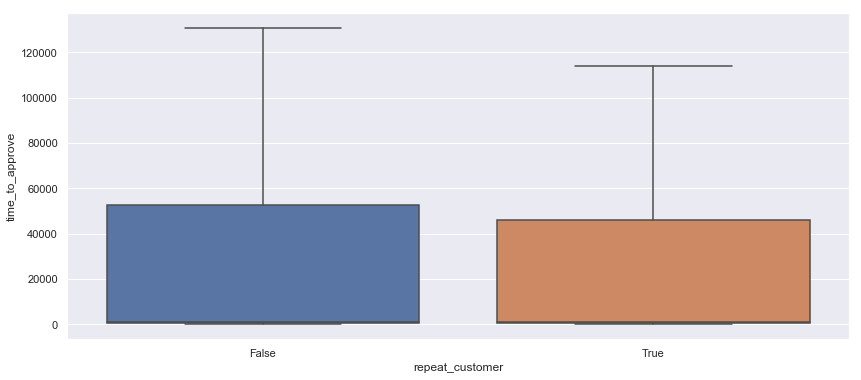

In [200]:
sns.boxplot(orders.repeat_customer, orders.time_to_approve, showfliers=False)